# CSC-321: Data Mining and Machine Learning

## Working with scikit-learn

In this notebook, I'll walk you through some elements of working with scikit learn.
For documentation, refer to: https://scikit-learn.org/stable/index.html

This notebook requires the Pima Indians diabetes data set.

I've used two new libraries. 
(1) scikit learn (sklearn)
(2) pandas

Pandas isn't strictly necessary, because there are other methods you can use to load and slice data. But it's one of the most highly used python libraries for data manipulation.

It basically brings the power of the data frame from R into python. You can find more here: https://pandas.pydata.org/

In this notebook there will be a demonstration of:
- preparing the data with pandas
- putting it into the right format for scikit learn
    - X values for training
    - y values for testing
    - in numpy array format
- performing cross-validations with a variety of models
- graphing the results
- performing a t-test between selected models
- then performing feature selection
- slicing out irrelevant features
- re-running one of the models on the new features

ZR: 0.651025 (0.072141)
LR: 0.769515 (0.048411)
KN5: 0.726555 (0.061821)
KN7: 0.744805 (0.056891)
DT: 0.704340 (0.061377)
NB: 0.755178 (0.042766)
SVM: 0.651025 (0.072141)
LIN: 0.772129 (0.046952)
RF: 0.770813 (0.057923)
NN: 0.667857 (0.063130)


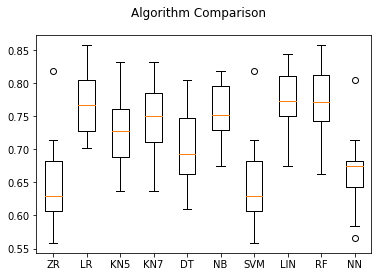


***Performing t-tests***


P-Val between ZeroR and Logistic Regression: 0.00
reject null hypothesis

P-Val between Logistic Regression and Naive Bayes: 0.15
accept null hypothesis


***Examining Features***


Feature names: ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
Feature ranking: [1 1 2 4 5 1 1 3]


***Slicing data to include ONLY features ranked 1***


NB: 0.765636 (0.044980)
LG: 0.769532 (0.045793)


In [24]:
# Compare Algorithms
# From scikit learn tutorial
# With modification by Nick Webb

%matplotlib inline

# Pandas is an important data manipulation library
# You don't have to use it for your project, but I include it
# here so you know about it.

import pandas
import matplotlib.pyplot as plt
from scipy import stats

# Import models

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

# And import the feature selection mechanism

from sklearn.feature_selection import RFE


# load dataset, using pandas

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv('pima-indians-diabetes.csv', names=names)


# get data from data frames, as numpy arrays
# note that by convention, we use X for input features
# and lower case y for the target class

array = dataframe.values
X = array[:,0:8]
y = array[:,8]


# prepare configuration for cross validation test harness
seed = 1

# prepare models
models = []
models.append(('ZR', DummyClassifier(strategy="most_frequent")))
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('KN5', KNeighborsClassifier()))
models.append(('KN7', KNeighborsClassifier(n_neighbors=7)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('LIN', SVC(kernel='linear',gamma='auto')))
models.append(('RF',RandomForestClassifier(n_estimators=100)))
models.append(('NN',MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)))

# evaluate each model in turn
# note that I'm going to run through each model above
# performing a 10-fold cross-validation each time
# (n_splits = 10), specifying 'accuracy' as my measure

results = []
classifiers = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	classifiers.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

    
    
# boxplot algorithm comparison

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(classifiers)
plt.show()

print('\n***Performing t-tests***\n\n')

    
ttest,pval = stats.ttest_rel(results[0], results[1])
print('P-Val between ZeroR and Logistic Regression: %.2f' % pval)

if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis") 

print()    
    
ttest,pval = stats.ttest_rel(results[1], results[5])
print('P-Val between Logistic Regression and Naive Bayes: %.2f' % pval)

if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")
   
print('\n\n***Examining Features***\n\n')

log = LogisticRegression(solver='liblinear')
rfe = RFE(estimator=log, step=1)
rfe.fit(X, y)
print("Feature names:",names)
print("Feature ranking:",rfe.ranking_)

print('\n\n***Slicing data to include ONLY features ranked 1***\n\n')

# I use pandas (badly) to do this, slicing by column names
# I extract the column names from the ranking, above
# There's better ways to do this, but it's late and I'm tired

newCols = []
index = 0
for i in rfe.ranking_:
    if i == 1:
        newCols.append(names[index])
    index+=1
newCols.append('class')    
newData = dataframe[dataframe.columns[dataframe.columns.isin(newCols)]]


# Extract the training and test data from the pandas data frame

array = newData.values

X = array[:,0:4]
y = array[:,4]

# I'm going to perform a single 10-fold cross-validation
# Using my new data, and just two models
# Naive Bayes and Logistic Regression

kfold = model_selection.KFold(n_splits=10, random_state=seed)

cv_results_1 = model_selection.cross_val_score(GaussianNB(), X, y, cv=kfold, scoring=scoring)
msg = "%s: %f (%f)" % ('NB', cv_results_1.mean(), cv_results_1.std())
print(msg)

cv_results_2 = model_selection.cross_val_score(LogisticRegression(solver='liblinear'), X, y, cv=kfold, scoring=scoring)
msg = "%s: %f (%f)" % ('LG', cv_results_2.mean(), cv_results_2.std())
print(msg)
